# Calculate and Compare FID Scores of Model Output

In [1]:
import tensorflow as tf
from keras import backend as K
import pathlib
import numpy as np
import pickle

from numpy import cov
#from numpy import trace
#from numpy import iscomplexobj
from scipy.linalg import sqrtm

### Load and Adjust InceptionV3 Model

In [2]:
# Load InceptionV3
tf.keras.backend.clear_session()
model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3)) #Inception V3 expects 299 x 299 input

### Load pre-calculated reference values for FID calculation

In [3]:
# Load pickled reference values for real 1024^2, 256^2, 128^2 and 12^2 images

# 1024
with open('fid_reference_values_1024','rb') as p1:
    mux_1024 = pickle.load(p1)
    sigmax_1024 = pickle.load(p1)

# 256, 128, 12
with open('fid_reference_values','rb') as p2:
    mux_256 = pickle.load(p2)
    sigmax_256 = pickle.load(p2)
    mux_128 = pickle.load(p2)
    sigmax_128 = pickle.load(p2)
    
# 12x12 (tiles)
with open('fid_reference_values_tiles','rb') as p3:
    mux_tile = pickle.load(p3)
    sigmax_tile = pickle.load(p3)

### Define FID function

based on https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

In [4]:
# calculate frechet inception distance
def calculate_fid(model, images, reference: tuple):    # calculate activations for images to compare to established baseline
    
    act = model.predict(images)
    
    # calculate mean and covariance statistics
    ''' Not necessary as unpickling put into separate step
    with open(reference, 'rb') as f:
        mu1 = pickle.load(f)
        sigma1 = pickle.load(f)
    '''
    mu1, sigma1 = reference
    
    mu2, sigma2 = act.mean(axis=0), np.cov(act, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    
    return fid

### Compare random generated images (DCGAN1024) against Reference

We load a random subset of generated images from a previous run into a tensor and run that through the calculate_fid() function

In [5]:
# load generated images
IMAGE_SIZE = (299, 299) # here we specify the expected input size of Inception V3 to let image_dataset_from_directory() automatically resize the images
BATCH_SIZE = 64

data_dir = pathlib.Path('/data/output/images/dwarfgan001/run01')

check = tf.keras.preprocessing.image_dataset_from_directory(  data_dir,
                                                              image_size=IMAGE_SIZE, 
                                                              batch_size=BATCH_SIZE, 
                                                              #labels=[0.] * len(imgs), # setting all labels to 0 (for 'fake'), not relevant here
                                                              #label_mode=None, # yields float32 type labels
                                                              seed=42,
                                                            )

result_dcgan = calculate_fid(model, check, (mux_1024, sigmax_1024))
print(f'We see that the result is quite large with a FID score of: {round(result_dcgan,2)}. A perfect imitation would score a FID score close to 0.')

Found 5 files belonging to 2 classes.
We see that the result is quite large with a FID score of: 307623.73. A perfect imitation would score a FID score close to 0.


### Calculate FID for Real Image Crops (256x256) - BASELINE

In [6]:
# load real images
IMAGE_SIZE = (299, 299) # here we specify the expected input size of Inception V3 to let image_dataset_from_directory() automatically resize the images
BATCH_SIZE = 64

data_dir = pathlib.Path('/data/input/crops_small/') # 256x256 crops of original map images
imgs = list(data_dir.glob('*.png'))

check = tf.keras.preprocessing.image_dataset_from_directory(  data_dir,
                                                              image_size=IMAGE_SIZE, 
                                                              batch_size=BATCH_SIZE, 
                                                              #labels=[0.] * len(imgs), # setting all labels to 0 (for 'fake'), not relevant here
                                                              #label_mode=None, # yields float32 type labels
                                                              seed=42,
                                                              validation_split=0.005, #only using 0.5% of ~500'000 = ~2'500
                                                              subset='validation'
                                                            )

result_real = calculate_fid(model, check, (mux_256, sigmax_256)) #specifying reference values for 256x256 images. This should yield a small value


Found 488044 files belonging to 1 classes.
Using 2440 files for validation.


In [7]:
print(f'Here we see a much lower FID score of: {round(result_real,2)}. Due to the variety of pictures, a score of 0 is unlikely.')

Here we see a much lower FID score of: 707.79. Due to the variety of pictures, a score of 0 is unlikely.


### Check DCGAN256 Generated Output

Since this model showed severe mode collapse, the check is run against output generated at epoch 500 rather than the last available state (epoch 1000)

In [8]:
# load real images
IMAGE_SIZE = (299, 299) # here we specify the expected input size of Inception V3 to let image_dataset_from_directory() automatically resize the images
BATCH_SIZE = 32

data_dir = '/data/output/images/DCGAN256FID/'
#imgs = list(data_dir.glob('*.png'))

check = tf.keras.preprocessing.image_dataset_from_directory(  data_dir,
                                                              image_size=IMAGE_SIZE, 
                                                              batch_size=BATCH_SIZE, 
                                                              #labels=[0.] * len(imgs), # setting all labels to 0 (for 'fake'), not relevant here
                                                              #label_mode=None, # yields float32 type labels
                                                              seed=42
                                                              #validation_split=0.025, #only 2.5% of 700'000 images as reference 
                                                              #subset='validation'
                                                            )

result_dcgan256 = calculate_fid(model, check, (mux_256, sigmax_256))

Found 6 files belonging to 2 classes.


In [9]:
print(f'Here we see a FID score of {round(result_dcgan256,2)} from the DCGAN256 model compared to {round(result_real, 2)} of the real image reference score.')

Here we see a FID score of 79057.59 from the DCGAN256 model compared to 707.79 of the real image reference score.


### Check WGAN-GP256 (RUN03) Generated Output

Here we use the last available generator example (epoch 50) of RUN03 of the WGAN-GP256 model.

In [10]:
# load real images
IMAGE_SIZE = (299, 299) # here we specify the expected input size of Inception V3 to let image_dataset_from_directory() automatically resize the images
BATCH_SIZE = 64

data_dir = '/data/output/images/WGANGP256FID/'
#imgs = list(data_dir.glob('*.png'))

check = tf.keras.preprocessing.image_dataset_from_directory(  data_dir,
                                                              image_size=IMAGE_SIZE, 
                                                              batch_size=BATCH_SIZE, 
                                                              #labels=[0.] * len(imgs), # setting all labels to 0 (for 'fake'), not relevant here
                                                              #label_mode=None, # yields float32 type labels
                                                              seed=42
                                                              #validation_split=0.025, #only 2.5% of 700'000 images as reference 
                                                              #subset='validation'
                                                            )

result_wgangp256 = calculate_fid(model, check, (mux_256, sigmax_256))
print(f'FID Score WGAN-GP256 (RUN03): {round(result_wgangp256,2)}')

Found 5 files belonging to 2 classes.
FID Score WGAN-GP256 (RUN03): 122312.85


Surprisingly this FID score is larger than the DCGAN256 one eventhough WGAN-GP RUN03 appears to create slightly more realistic images. Still, the size of the scores indicates that the generated images are far away from the original input data.

### Check WGAN-GP128 (RUN05) Generated Output

In [11]:
# load real images
IMAGE_SIZE = (299, 299) # here we specify the expected input size of Inception V3 to let image_dataset_from_directory() automatically resize the images
BATCH_SIZE = 5

data_dir = '/data2/output/images/WGANGPR05FID/'
#imgs = list(data_dir.glob('*.png'))

check = tf.keras.preprocessing.image_dataset_from_directory(  data_dir,
                                                              image_size=IMAGE_SIZE, 
                                                              batch_size=BATCH_SIZE, 
                                                              #labels=[0.] * len(imgs), # setting all labels to 0 (for 'fake'), not relevant here
                                                              #label_mode=None, # yields float32 type labels
                                                              seed=42
                                                              #validation_split=0.025, #only 2.5% of 700'000 images as reference 
                                                              #subset='validation'
                                                            )

result_wgangp128r5 = calculate_fid(model, check, (mux_128, sigmax_128))
print(f'FID Score WGAN-GP128 (RUN05): {round(result_wgangp128r5,2)}')

Found 5 files belonging to 2 classes.
FID Score WGAN-GP128 (RUN05): 49363.99


### Check WGAN-GP128 (RUN07) Generated Output

In [12]:
# load real images
IMAGE_SIZE = (299, 299) # here we specify the expected input size of Inception V3 to let image_dataset_from_directory() automatically resize the images
BATCH_SIZE = 5

data_dir = '/data2/output/images/WGANGPR07FID/'
#imgs = list(data_dir.glob('*.png'))

check = tf.keras.preprocessing.image_dataset_from_directory(  data_dir,
                                                              image_size=IMAGE_SIZE, 
                                                              batch_size=BATCH_SIZE, 
                                                              #labels=[0.] * len(imgs), # setting all labels to 0 (for 'fake'), not relevant here
                                                              #label_mode=None, # yields float32 type labels
                                                              seed=42
                                                              #validation_split=0.025, #only 2.5% of 700'000 images as reference 
                                                              #subset='validation'
                                                            )

result_wgangp128r7 = calculate_fid(model, check, (mux_128, sigmax_128))
print(f'FID Score WGAN-GP128 (RUN07): {round(result_wgangp128r7,2)}')

Found 7 files belonging to 2 classes.
FID Score WGAN-GP128 (RUN07): 57108.33


### Check WGAN-GP128 (RUN08) Generated Output

In [13]:
# load real images
IMAGE_SIZE = (299, 299) # here we specify the expected input size of Inception V3 to let image_dataset_from_directory() automatically resize the images
BATCH_SIZE = 5

data_dir = '/data2/output/images/WGANGPR08FID/'
#imgs = list(data_dir.glob('*.png'))

check = tf.keras.preprocessing.image_dataset_from_directory(  data_dir,
                                                              image_size=IMAGE_SIZE, 
                                                              batch_size=BATCH_SIZE, 
                                                              #labels=[0.] * len(imgs), # setting all labels to 0 (for 'fake'), not relevant here
                                                              #label_mode=None, # yields float32 type labels
                                                              seed=42
                                                              #validation_split=0.025, #only 2.5% of 700'000 images as reference 
                                                              #subset='validation'
                                                            )

result_wgangp128r8 = calculate_fid(model, check, (mux_128, sigmax_128))
print(f'FID Score WGAN-GP128 (RUN08): {round(result_wgangp128r8,2)}')

Found 10 files belonging to 2 classes.
FID Score WGAN-GP128 (RUN08): 62711.06


### Check WGAN-GPTiles (RUN09NoTiles) Generated Output

In [22]:
# load real images
IMAGE_SIZE = (299, 299) # here we specify the expected input size of Inception V3 to let image_dataset_from_directory() automatically resize the images
BATCH_SIZE = 5

data_dir = '/data2/output/images/WGANGPR09FID/'
#imgs = list(data_dir.glob('*.png'))

check = tf.keras.preprocessing.image_dataset_from_directory(  data_dir,
                                                              image_size=IMAGE_SIZE, 
                                                              batch_size=BATCH_SIZE, 
                                                              #labels=[0.] * len(imgs), # setting all labels to 0 (for 'fake'), not relevant here
                                                              #label_mode=None, # yields float32 type labels
                                                              seed=42
                                                              #validation_split=0.025, #only 2.5% of 700'000 images as reference 
                                                              #subset='validation'
                                                            )

result_wgangpr9notiles = calculate_fid(model, check, (mux_tile, sigmax_tile))
print(f'FID Score WGAN-GP RUN09NoTiles: {round(result_wgangpr9notiles,2)}')

Found 5 files belonging to 2 classes.
FID Score WGAN-GP RUN09NoTiles: 120974.43


### Check WGAN-GPTiles (RUN09Tiles) Generated Output

In [20]:
# load real images
IMAGE_SIZE = (299, 299) # here we specify the expected input size of Inception V3 to let image_dataset_from_directory() automatically resize the images
BATCH_SIZE = 5

data_dir = '/data2/output/images/WGANGPR09TilesFID/'
#imgs = list(data_dir.glob('*.png'))

check = tf.keras.preprocessing.image_dataset_from_directory(  data_dir,
                                                              image_size=IMAGE_SIZE, 
                                                              batch_size=BATCH_SIZE, 
                                                              #labels=[0.] * len(imgs), # setting all labels to 0 (for 'fake'), not relevant here
                                                              #label_mode=None, # yields float32 type labels
                                                              seed=42
                                                              #validation_split=0.025, #only 2.5% of 700'000 images as reference 
                                                              #subset='validation'
                                                            )

result_wgangpr9tiles = calculate_fid(model, check, (mux_tile, sigmax_tile))
print(f'FID Score WGAN-GP RUN09Tiles: {round(result_wgangpr9tiles,2)}')

Found 5 files belonging to 2 classes.
FID Score WGAN-GP RUN09Tiles: 75054.09


# Overview FID Score Development

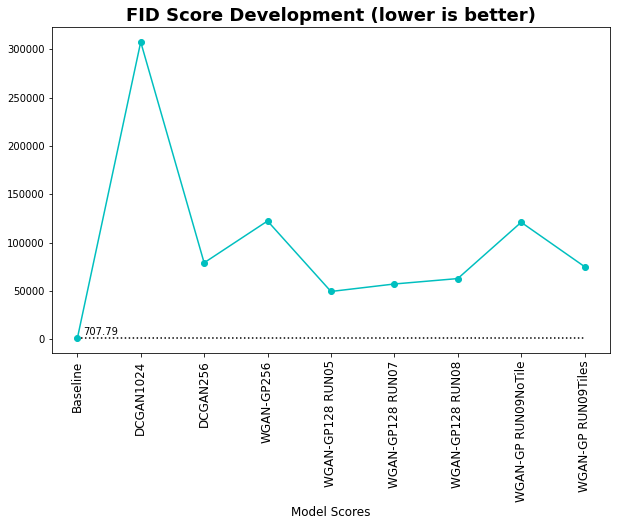

In [23]:
import matplotlib.pyplot as plt

#build data tuple
data = (result_real, result_dcgan, result_dcgan256, result_wgangp256, result_wgangp128r5, result_wgangp128r7, result_wgangp128r8, result_wgangpr9notiles, result_wgangpr9tiles)

#create plot

plt.figure(figsize=(10,6))

plt.title('FID Score Development (lower is better)', 
          fontsize=18, 
          fontweight='bold')

plt.xlabel('Model Scores', 
           fontsize=12)

plt.xticks([i for i in range(len(data))], 
           ('Baseline','DCGAN1024','DCGAN256','WGAN-GP256','WGAN-GP128 RUN05','WGAN-GP128 RUN07','WGAN-GP128 RUN08','WGAN-GP RUN09NoTile', 'WGAN-GP RUN09Tiles'), 
           rotation=90, 
           fontsize=12)

# baseline reference value
plt.hlines(data[0],
           0, 
           len(data)-1, 
           colors='black', 
           linestyle='dotted')

plt.annotate(round(data[0],2)
             , (0.1, 4000)
            )

#show plot
plt.plot(data, 'co-')


